# Messing Around

Play around with a few MLFlow setup tasks, create a missing experiment if we don't have a sandbox set up, other basic tasks.

In [21]:
# MLFlow setup

import mlflow

# Manually specify this uri when launching the server in $HOME with mlflow ui --port 8080
# Setting the tracking uri to the one launched from home will prevent a new mlflow instance in each directory
mlflow.set_tracking_uri("http://127.0.0.1:8080")
client = mlflow.MlflowClient()

# Search for the experiment we want to be working in, which will be sandbox as we play around
experiment_list = client.search_experiments(filter_string="name = 'sandbox'")

if len(experiment_list) == 0:

    # Provide an Experiment description that will appear in the UI
    experiment_description = "This is a sandbox experiment"

    # Provide searchable tags that define characteristics of the Runs that
    # will be in this Experiment
    experiment_tags = {
        "project_name": "sandbox",
        "mlflow.note.content": experiment_description,
    }

    # Create the Experiment, providing a unique name
    sandbox_experiment = client.create_experiment(name="sandbox", tags=experiment_tags)
    experiment_list = client.search_experiments(filter_string="name = 'sandbox'")

experiment_id = experiment_list[0].experiment_id
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/987389467457786153', creation_time=1708729394817, experiment_id='987389467457786153', last_update_time=1708729394817, lifecycle_stage='active', name='sandbox', tags={'mlflow.note.content': 'This is a sandbox experiment',
 'project_name': 'sandbox'}>

In [26]:
# Load data

from sklearn.datasets import load_iris

mlflow.autolog()
iris = load_iris()

2024/02/23 15:14:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/23 15:14:12 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/02/23 15:14:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


2024/02/23 15:14:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b5ec29eddfa84c87a158359694b85c6d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/mheffernan/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024/02/23 15:14:12 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/02/23 15:14:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mheffernan/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is repla

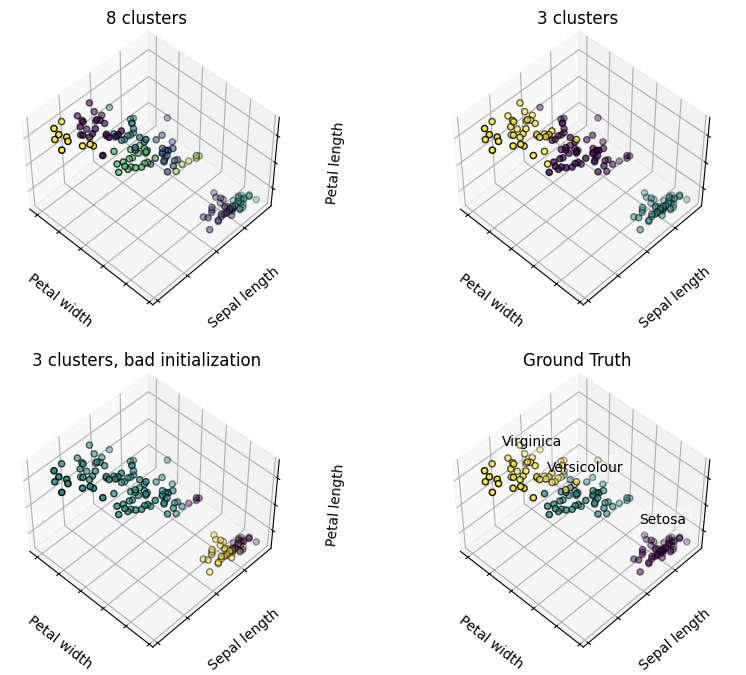

In [27]:
# Copy some analysis from the sklearn documentation
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt

# Though the following import is not directly being used, it is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn import datasets
from sklearn.cluster import KMeans

X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fig = plt.figure(figsize=(10, 8))
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(title)

# Plot the ground truth
ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

In [30]:
estimators[1][1]

KMeans(n_clusters=3)

In [32]:
model = estimators[1][1]
mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path="sklearn-model",
    signature=mlflow.models.infer_signature(X, y),
    registered_model_name="iris-kmeans-3cluster",
)

Successfully registered model 'iris-kmeans-3cluster'.
2024/02/23 15:18:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris-kmeans-3cluster, version 1
Created version '1' of model 'iris-kmeans-3cluster'.


So this is actually fairly simple, there are undoubtedly utils that one could build on top of this, but it looks fairly straightforward to build and track things this way as well as register them to a central store. 

Let's see what we can do with this and fitting a GP.